# Backpropagation Momentum

## 1. Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import time

## 2. Fungsi Normalisasi

In [2]:
def normalization(array): #dataset pandas dataframe
    array_norm = (array-np.min(array)) / (np.max(array)-np.min(array))
    return array_norm

## 3. Fungsi Conversi Data Input

In [3]:
def convToDataProccess(dataset, dataInput):
    x=dataInput
    num = dataset.to_numpy()
    num=num.reshape(num.size)
    newData=[]
    for i in range(num.size-x):
        row=[]
        for j in range(i,x+i+1):
            row.append(num[j])
        newData.append(row)
    hasil = np.array(newData)
    return hasil[:, :dataInput].reshape(len(hasil), dataInput, 1), hasil[:, dataInput:].reshape(len(hasil),1)


## 4. Fungsi Splitting Data

In [4]:
def dataSplitting(data, train, test):#persen / desimal 0.7 0.3
    train=round(len(data[0])*train)
    test=round(len(data[0])*test)
    xtrain, ytrain, xtest, ytest = data[0][:train], data[1][:train], data[0][train:], data[1][train:]
    return xtrain, ytrain, xtest, ytest

## 5. Fungsi Denormalisasi dan Grafik Prediksi

In [5]:
def denormalisasi(arraynorm, minActual, maxActual):
    denormalized_array = (arraynorm * (maxActual - minActual)) + minActual
    return denormalized_array
def grafPrediksi(denorm, datatest):    
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [25, 8]   
    plt.plot(denorm, label='predict result')
    plt.plot(datatest, label='Actual Data')
    plt.xlabel('th data')
    plt.ylabel('Predict')
    plt.title('backpropagation prediction results')
    plt.legend()
    plt.show()

## 6. Fungsi Progress

In [6]:
def process(epoch, i):
    progress = (i + 1) / epoch * 100
    # Membuat string loading
    loading_string = f"Proses Training: {int(progress)}% [{'=' * round(progress*60/100)}>] {i+1}/{epoch} "
    print(loading_string, end='\r')

## 7. Class Backpropagation

In [7]:
class backpropagation:
    def __init__(self, arch,lr, momentum, epochs, mse):# arch = [4,7,1]
        self.lr = lr
        self.momentum=momentum
        self.mse = mse
        self.timer = None
        self.waktu = 0
        self.epochs = epochs
        if arch!=[]:
            self.x, self.h, self.y = arch[0], arch[1], arch[2]
            self.weights(self.x, self.h, self.y)        
        
    def start_time(self):
        self.timer = time.time()
        
    def stop_timer(self):
        if self.timer is not None:
            elapsed_time = time.time() - self.timer
            self.timer = None
            return elapsed_time
        else:
            return None
    def weights(self, x, h, y):
        self.W1 = np.random.randn(h, x) #7,4
        self.b1 = np.zeros((h, 1)) #(7,1)
        self.W2 = np.random.randn(y, h) #1,7
        self.b2 = np.zeros((y, 1))
    
    def Funcz_in(self, x, W, b):
        z_in =np.dot(W, x) + b
        return z_in
    
    def sigmoid(self, z_in):
        z=1/(1 + np.exp(-z_in))
        return z
    
    def sigmoid_derivative(self, y_in):
        sigmoidx = self.sigmoid(y_in)
        return sigmoidx * (1 - sigmoidx)
    
    def forward(self, x):
#       lapisan pertama
        self.z_in=self.Funcz_in(x, self.W1, self.b1)
        self.z=self.sigmoid(self.z_in)
#       lapisan output
        self.y_in=self.Funcz_in(self.z, self.W2, self.b2)
        self.y=self.sigmoid(self.y_in)
    
    def backpro(self, x, Y, lambda_reg=0.01):
        #lapisan akhir
        self.err=self.y-Y
        self.delta2 = self.err*self.sigmoid_derivative(self.y_in)
        self.dW2 = np.dot(self.delta2, self.z.T)
        self.db2 = np.sum(self.delta2, axis=1, keepdims=True)
        #lapisan hiden layer
        self.delta1 = np.dot(self.W2.T, self.delta2) * self.sigmoid_derivative(self.z_in)
        self.dW1 = np.dot(self.delta1, x.T) 
        self.db1 = np.sum(self.delta1, axis=1, keepdims=True)
        #koreksi bobot dan bias lapisan terakhir
        if hasattr(self, 'dW1_prev'):
            self.dW1 += self.dW1_prev *self.momentum
            self.dW2 += self.dW2_prev *self.momentum
        self.W1correction=self.lr*self.dW1 
        self.b1correction=self.lr*self.db1 
        #lapisan hiden layer
        self.W2correction=self.lr*self.dW2 
        self.b2correction=self.lr*self.db2 
        #simpan delta sebelumnya
        self.dW1_prev = self.dW1.copy()
        self.dW2_prev = self.dW2.copy()
        #updatebobot
        self.W2 -= self.W2correction 
        self.b2 -= self.b2correction 
        self.W1 -= self.W1correction 
        self.b1 -= self.b1correction 
    
    def Funcmse(self, actual, prediction):
        error =actual-prediction
        squared = np.square(error)
        return squared
    
    def fit(self, X, Y):
        self.Xtrain, self.Ytrain = X, Y
        self.W1correction, self.b1correction, self.W2correction, self.b2correction = np.array([]), np.array([]), np.array([]), np.array([])
        data, epoch, msenow, mseepoch=0, 0, 0, 0
        self.arrayError=np.array([]) #menghitung error per epoch
        num_batch = len(self.Xtrain) // 32
        self.start_time()
        while epoch<self.epochs: #epoch 
            self.error=np.array([]) #menyimpan error setiap data   
            for batch in range (num_batch):
                start, end = batch * 32, (batch +1) * 32
                for data in range(start, end) : #iteration
                    self.forward(self.Xtrain[data])
                    self.backpro(self.Xtrain[data], self.Ytrain[data])
                    msenow = self.Funcmse(self.Ytrain[data], self.y)
                    self.error=np.append(self.error, msenow)
            mseepoch=np.mean(self.error)
            process(self.epochs, epoch)
            self.arrayError=np.append(self.arrayError, mseepoch)
            epoch+=1
            if mseepoch<=self.mse:
                break
        self.iterasi = epoch
        self.waktu=self.stop_timer()
        
    def test(self, X, Y):
        self.Xtest, self.Ytest = X, Y
        self.msenow = 0
        self.arraymse = np.array([])
        self.arrayofY=np.array([])
        for data in range(len(self.Xtest)):
            self.forward(self.Xtest[data])
            msenow = self.Funcmse(self.Ytest, self.y)
            self.arraymse = np.append(self.arraymse, msenow)
            self.arrayofY = np.append(self.arrayofY, self.y)
        self.msetest = np.mean(self.arraymse)
        print(f"Testing MSE: {self.msetest}")
        
#         grafik sewaktu training
    def graf(self):
        %matplotlib inline
        plt.rcParams['figure.figsize'] = [8, 6]
        plt.plot(range(1, self.epochs+1), self.arrayError)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE by Epoch')
        plt.show()
        
    def prediksi(self, data,xinput,yinput):
        self.databaruArray = denormalisasi(self.X, np.min(xinput), np.max(xinput))
        self.databaruArray = self.databaruArray[len(self.databaruArray)-1]
        r=len(self.databaruArray)
        self.dataY = denormalisasi(self.Y, np.min(yinput), np.max(yinput))
        self.dataY = self.dataY[len(self.dataY)-1]
        newlist=np.concatenate((np.squeeze(self.databaruArray[2:r]),self.dataY, np.array([data])))
        newlist=newlist.reshape(-1, 1)
        self.forward(newlist)
        self.hasil = denormalisasi(self.y, np.min(yinput), np.max(yinput))
        print("Hasil Prediksi : ", round(self.hasil[0,0]))

    def predict(self, listinput):#numpy type
        if len(listinput)!=self.x:
            print("Jumlah data Input harus", self.arch[0])
        else:
            self.dataInput = normalization(listinput)
            self.forward(self.dataInput)
            return self.y
    def simpanModel(self,name):       
        self.model_name=name
        model_data = {
            'W1': self.W1.tolist(),
            'W2': self.W2.tolist(),
            'b1' : self.b1.tolist(),
            'b2' : self.b2.tolist(),
            'err' : self.arrayError.tolist(),
            'timer' : self.waktu,
            'iterasi' : self.iterasi
        }
        
        with open(name, 'w') as file:
            json.dump(model_data, file)  
        print("Model telah disimpan dalam berkas:", name)
                
    def loadModel(self, jsonfile):
        with open(jsonfile, 'r') as file:
            loadedFile = json.load(file)
        self.W1 = np.array(loadedFile["W1"])
        self.W2 = np.array(loadedFile["W2"])
        self.b1 = np.array(loadedFile["b1"])
        self.b2 = np.array(loadedFile["b2"])
        self.arrayError = np.array(loadedFile["err"])
        self.waktu = loadedFile['timer']
        self.iterasi = loadedFile['iterasi']
        print("Berhasil Load Model",jsonfile)
        

# 8. Backpropagation Non Momentum

In [8]:
class backpropagation_b:
    def __init__(self, arch,lr, epochs, mse):# arch = [4,7,1]
        self.lr = lr
#         self.momentum=momentum
        self.mse = mse
        self.timer = None
        self.waktu = 0
        self.epochs = epochs
        if arch!=[]:
            self.x, self.h, self.y = arch[0], arch[1], arch[2]
            self.weights(self.x, self.h, self.y)        
        
    def start_time(self):
        self.timer = time.time()
        
    def stop_timer(self):
        if self.timer is not None:
            elapsed_time = time.time() - self.timer
            self.timer = None
            return elapsed_time
        else:
            return None
    def weights(self, x, h, y):
        self.W1 = np.random.randn(h, x) #7,4
        self.b1 = np.zeros((h, 1)) #(7,1)
        self.W2 = np.random.randn(y, h) #1,7
        self.b2 = np.zeros((y, 1))
    
    def Funcz_in(self, x, W, b):
        z_in =np.dot(W, x) + b
        return z_in
    
    def sigmoid(self, z_in):
        z=1/(1 + np.exp(-z_in))
        return z
    
    def sigmoid_derivative(self, y_in):
        sigmoidx = self.sigmoid(y_in)
        return sigmoidx * (1 - sigmoidx)
    
    def forward(self, x):
#       lapisan pertama
        self.z_in=self.Funcz_in(x, self.W1, self.b1)
        self.z=self.sigmoid(self.z_in)
#       lapisan output
        self.y_in=self.Funcz_in(self.z, self.W2, self.b2)
        self.y=self.sigmoid(self.y_in)
    
    def backpro(self, x, Y):
        # Lapisan akhir
        self.err = self.y - Y
        self.delta2 = self.err * self.sigmoid_derivative(self.y_in)
        self.dW2 = np.dot(self.delta2, self.z.T)
        self.db2 = np.sum(self.delta2, axis=1, keepdims=True)
        # Lapisan hidden layer
        self.delta1 = np.dot(self.W2.T, self.delta2) * self.sigmoid_derivative(self.z_in)
        self.dW1 = np.dot(self.delta1, x.T)
        self.db1 = np.sum(self.delta1, axis=1, keepdims=True)
        # Koreksi bobot dan bias lapisan terakhir
        self.W1correction = self.lr * self.dW1
        self.b1correction = self.lr * self.db1
        # Lapisan hidden layer
        self.W2correction = self.lr * self.dW2
        self.b2correction = self.lr * self.db2
        # Update bobot
        self.W2 -= self.W2correction
        self.b2 -= self.b2correction
        self.W1 -= self.W1correction
        self.b1 -= self.b1correction
   
    def Funcmse(self, actual, prediction):
        error =actual-prediction
        squared = np.square(error)
        return squared
    
    def fit(self, X, Y):
        self.Xtrain, self.Ytrain = X, Y
        self.W1correction, self.b1correction, self.W2correction, self.b2correction = np.array([]), np.array([]), np.array([]), np.array([])
        data, epoch, msenow, mseepoch=0, 0, 9, 0
        self.arrayError=np.array([]) #menghitung error per epoch
        num_batch = len(self.Xtrain) // 32
        self.start_time()
        while epoch<self.epochs: #epoch 
            self.error=np.array([]) #menyimpan error setiap data   
            for batch in range (num_batch):
                start, end = batch * 32, (batch +1) * 32
                for data in range(start, end) : #iteration
                    self.forward(self.Xtrain[data])
                    self.backpro(self.Xtrain[data], self.Ytrain[data])
                    msenow = self.Funcmse(self.Ytrain[data], self.y)
                    self.error=np.append(self.error, msenow)
            mseepoch=np.mean(self.error)
            process(self.epochs, epoch)
            self.arrayError=np.append(self.arrayError, mseepoch)
            epoch+=1
            if mseepoch<=self.mse:
                self.iterasi = epoch
                break
            
        self.waktu=self.stop_timer()
        self.iterasi = epoch
    def test(self, X, Y):
        self.Xtest, self.Ytest = X, Y
        self.msenow = 0
        self.arraymse = np.array([])
        self.arrayofY=np.array([])
        for data in range(len(self.Xtest)):
            self.forward(self.Xtest[data])
            msenow = self.Funcmse(self.Ytest, self.y)
            self.arraymse = np.append(self.arraymse, msenow)
            self.arrayofY = np.append(self.arrayofY, self.y)
        self.msetest = np.mean(self.arraymse)
        print(f"Testing MSE: {self.msetest}")
        
#         grafik sewaktu training
    def graf(self):
        %matplotlib inline
        plt.rcParams['figure.figsize'] = [8, 6]
        plt.plot(range(1, self.epochs+1), self.arrayError)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE by Epoch')
        plt.show()
        
    def prediksi(self, data,xinput,yinput):
        self.databaruArray = denormalisasi(self.X, np.min(xinput), np.max(xinput))
        self.databaruArray = self.databaruArray[len(self.databaruArray)-1]
        r=len(self.databaruArray)
        self.dataY = denormalisasi(self.Y, np.min(yinput), np.max(yinput))
        self.dataY = self.dataY[len(self.dataY)-1]
        newlist=np.concatenate((np.squeeze(self.databaruArray[2:r]),self.dataY, np.array([data])))
        newlist=newlist.reshape(-1, 1)
        self.forward(newlist)
        self.hasil = denormalisasi(self.y, np.min(yinput), np.max(yinput))
        print("Hasil Prediksi : ", round(self.hasil[0,0]))

    def predict(self, listinput):#numpy type
        if len(listinput)!=self.x:
            print("Jumlah data Input harus", self.arch[0])
        else:
            self.dataInput = normalization(listinput)
            self.forward(self.dataInput)
            return self.y
    def simpanModel(self,name):       
        self.model_name=name
        model_data = {
            'W1': self.W1.tolist(),
            'W2': self.W2.tolist(),
            'b1' : self.b1.tolist(),
            'b2' : self.b2.tolist(),
            'err' : self.arrayError.tolist(),
            'timer' : self.waktu,
            'iterasi' : self.iterasi
        }
        
        with open(name, 'w') as file:
            json.dump(model_data, file)  
        print("Model telah disimpan dalam berkas:", name)
                
    def loadModel(self, jsonfile):
        with open(jsonfile, 'r') as file:
            loadedFile = json.load(file)
        self.W1 = np.array(loadedFile["W1"])
        self.W2 = np.array(loadedFile["W2"])
        self.b1 = np.array(loadedFile["b1"])
        self.b2 = np.array(loadedFile["b2"])
        self.arrayError = np.array(loadedFile["err"])
        self.waktu = loadedFile['timer']
        self.iterasi = loadedFile['iterasi']
        print("Berhasil Load Model",jsonfile)
        

# I. PreProcessing Data

In [39]:
tabs.describe()

,lr,momentum,iterasi,time,MSE,MSE_test
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.074000,0.600000,862.935185,73.045289,0.003683,0.200760
std,0.089815,0.246091,304.392156,26.710027,0.001917,0.152005
min,0.002000,0.300000,61.000000,5.005736,0.000985,0.003958
25%,0.002000,0.300000,1000.000000,71.699930,0.002686,0.062407
50%,0.020000,0.600000,1000.000000,82.202759,0.003266,0.290017
75%,0.200000,0.900000,1000.000000,90.180246,0.005474,0.335577
max,0.200000,0.900000,1000.000000,107.313208,0.009258,0.377913


In [36]:
tabs = pd.DataFrame(tabel_bm)
tabs.head()

,Batik,Arsitektur,lr,momentum,iterasi,time,MSE,MSE_test
0,batikcap,"[4, 7, 1]",0.20,0.6,1000,71.744024,0.005472,0.297521
1,batikcap,"[4, 7, 1]",0.20,0.3,1000,75.401120,0.005478,0.308421
2,batikcap,"[4, 7, 1]",0.20,0.9,1000,74.879483,0.005226,0.301986
3,batikcap,"[4, 7, 1]",0.02,0.6,1000,74.160703,0.005677,0.324680
4,batikcap,"[4, 7, 1]",0.02,0.3,1000,95.492149,0.005665,0.327352


In [35]:
models = os.listdir('BPM')
kolom = ['batikcap', 'batiktulis','semitulis','semiwarna']
arch = [4,7,1], [6,6,1], [8,13,1]
learning_rate = 0.2, 0.02, 0.002
momentum = 0.6, 0.3, 0.9
tabel_bm={'Batik':[], 'Arsitektur':[], 'lr':[], 'momentum':[], 'iterasi':[], 'time':[], 'MSE' :[], 'MSE_test':[]}
i=-1
for batik in batik_unique:
    i+=1
    for skenario in arch:
        for lr in learning_rate:
            for moment in momentum:
                for path in models:
                    if kolom[i] in path and str(skenario) in path and str(lr) in path and str(moment) in path:
                        path_select = path
                        break
                
                datainput =xinput, yinput=convToDataProccess(batik, skenario[0])
                dataproses = normalization(xinput), normalization(yinput)
                xtrain, ytrain, xtest, ytest = dataSplitting(dataproses ,0.7, 0.3)
                
                #make a model self, arch,lr, epochs, mse)
                model=backpropagation(skenario, lr, moment,1000, 0.0001)
                model.loadModel('BPM/'+path_select)
                model.test(xtest,ytest)
                            
                testing = model.msetest
                times = model.waktu
                err = model.arrayError[-1]
                
    #           add on tabel
                tabel_bm['Batik'].append(kolom[i])
                tabel_bm['Arsitektur'].append(str(skenario))
                tabel_bm['lr'].append(lr)
                tabel_bm['momentum'].append(moment)
                tabel_bm['iterasi'].append(model.iterasi)
                tabel_bm['time'].append(times)
                tabel_bm['MSE'].append(err)
                tabel_bm['MSE_test'].append(testing)

Berhasil Load Model BPM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.6 epochs=1000.json
Testing MSE: 0.2975212818091757
Berhasil Load Model BPM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.3 epochs=1000.json
Testing MSE: 0.3084211909006504
Berhasil Load Model BPM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.9 epochs=1000.json
Testing MSE: 0.3019864263797297
Berhasil Load Model BPM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.02 momentum=0.6 epochs=1000.json
Testing MSE: 0.32468049252889924
Berhasil Load Model BPM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.02 momentum=0.3 epochs=1000.json
Testing MSE: 0.3273517817884937
Berhasil Load Model BPM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.02 momentum=0.9 epochs=1000.json
Testing MSE: 0.3107657257261377
Berhasil Load Model BPM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.002 momentum=0.6 epochs=1000.json
Testing MSE: 0.3227527433

Testing MSE: 0.3760590036854941
Berhasil Load Model BPM/batik=semitulis skenario arch=[4, 7, 1] learning_rate=0.002 momentum=0.6 epochs=1000.json
Testing MSE: 0.3661519365875035
Berhasil Load Model BPM/batik=semitulis skenario arch=[4, 7, 1] learning_rate=0.002 momentum=0.3 epochs=1000.json
Testing MSE: 0.3632624413651269
Berhasil Load Model BPM/batik=semitulis skenario arch=[4, 7, 1] learning_rate=0.002 momentum=0.9 epochs=1000.json
Testing MSE: 0.3724817464375724
Berhasil Load Model BPM/batik=semitulis skenario arch=[6, 6, 1] learning_rate=0.2 momentum=0.6 epochs=1000.json
Testing MSE: 0.3747668234266062
Berhasil Load Model BPM/batik=semitulis skenario arch=[6, 6, 1] learning_rate=0.2 momentum=0.3 epochs=1000.json
Testing MSE: 0.37463051485693954
Berhasil Load Model BPM/batik=semitulis skenario arch=[6, 6, 1] learning_rate=0.2 momentum=0.9 epochs=1000.json
Testing MSE: 0.37669880914679194
Berhasil Load Model BPM/batik=semitulis skenario arch=[6, 6, 1] learning_rate=0.02 momentum=0.6 

# Tabel Training Backpropagation Momentum

In [32]:
tab.describe()

,lr,iterasi,time,MSE,MSE_test
count,36.000000,36.0,36.000000,36.000000,36.000000
mean,0.074000,1000.0,72.646251,0.004278,0.207831
std,0.090666,0.0,10.190813,0.002361,0.157924
min,0.002000,1000.0,57.261379,0.000420,0.003937
25%,0.002000,1000.0,64.113781,0.003041,0.058517
50%,0.020000,1000.0,70.721701,0.004212,0.312015
75%,0.200000,1000.0,76.456492,0.005771,0.358525
max,0.200000,1000.0,92.265685,0.009064,0.429470


In [31]:
tab = pd.DataFrame(tabel)
tab.head()

,Batik,Arsitektur,lr,iterasi,time,MSE,MSE_test
0,batikcap,"[4, 7, 1]",0.200,1000,68.931791,0.005508,0.316315
1,batikcap,"[4, 7, 1]",0.020,1000,73.473531,0.005746,0.328335
2,batikcap,"[4, 7, 1]",0.002,1000,62.749585,0.008298,0.318918
3,batikcap,"[6, 6, 1]",0.200,1000,67.329125,0.005540,0.312329
4,batikcap,"[6, 6, 1]",0.020,1000,60.459094,0.005710,0.328823


In [30]:
models = os.listdir('BPNM')
kolom = ['batikcap', 'batiktulis','semitulis','semiwarna']
arch = [4,7,1], [6,6,1], [8,13,1]
learning_rate = 0.2, 0.02, 0.002
# momentum = 0.6, 0.3, 0.9
tabel={'Batik':[], 'Arsitektur':[], 'lr':[], 'iterasi':[], 'time':[], 'MSE' :[], 'MSE_test':[]}
i=-1
for batik in batik_unique:
    i+=1
    for skenario in arch:
        for lr in learning_rate:
            for path in models:
                if kolom[i] in path and str(skenario) in path and str(lr) in path:
                    path_select = path
                    break
            #data proses
            datainput =xinput, yinput=convToDataProccess(batik, skenario[0])
            dataproses = normalization(xinput), normalization(yinput)
            xtrain, ytrain, xtest, ytest = dataSplitting(dataproses ,0.7, 0.3)
            
            #make a model self, arch,lr, epochs, mse)
            model=backpropagation_b(skenario, lr, 1000, 0.0001)
            model.loadModel('BPNM/'+path_select)
            model.test(xtest,ytest)
            
            testing = model.msetest
            times = model.waktu
            err = model.arrayError[-1]
            iterasi = model.iterasi
#           add on tabel
            tabel['Batik'].append(kolom[i])
            tabel['Arsitektur'].append(str(skenario))
            tabel['lr'].append(lr)
            tabel['iterasi'].append(iterasi)
            tabel['time'].append(times)
            tabel['MSE'].append(err)
            tabel['MSE_test'].append(testing)

Berhasil Load Model BPNM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 epochs=1000.json
Testing MSE: 0.31631492326915034
Berhasil Load Model BPNM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.02 epochs=1000.json
Testing MSE: 0.32833462465697166
Berhasil Load Model BPNM/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.002 epochs=1000.json
Testing MSE: 0.31891775978912384
Berhasil Load Model BPNM/batik=batikcap skenario arch=[6, 6, 1] learning_rate=0.2 epochs=1000.json
Testing MSE: 0.3123286080298374
Berhasil Load Model BPNM/batik=batikcap skenario arch=[6, 6, 1] learning_rate=0.02 epochs=1000.json
Testing MSE: 0.3288231192268018
Berhasil Load Model BPNM/batik=batikcap skenario arch=[6, 6, 1] learning_rate=0.002 epochs=1000.json
Testing MSE: 0.3154897724282485
Berhasil Load Model BPNM/batik=batikcap skenario arch=[8, 13, 1] learning_rate=0.2 epochs=1000.json
Testing MSE: 0.3117004425348499
Berhasil Load Model BPNM/batik=batikcap skenario arch=[8, 13, 1] learning

In [26]:
arch = [4,7,1], [6,6,1], [8,13,1]
learning_rate = 0.2, 0.02, 0.002
# momentum = 0.6, 0.3, 0.9
tabel={'Batik':[], 'Arsitektur':[], 'lr':[], 'momentum':[], 'iterasi':[], 'time':[], 'MSE' :[], 'MSE_test':[]}
models=os.listdir('BPM')
tabel

{'Batik': [],
 'Arsitektur': [],
 'lr': [],
 'momentum': [],
 'iterasi': [],
 'time': [],
 'MSE': [],
 'MSE_test': []}

# Tabel Backpropagation Non Momentum Training

In [24]:
arch = [4,7,1], [6,6,1], [8,13,1]
learning_rate = 0.2, 0.02, 0.002
momentum = 0.6, 0.3, 0.9
i=-1
for batik in batik_unique:
    i+=1
    for skenario in arch:
        for lr in learning_rate:
            for moment in momentum:
                path=f"batik={kolom[i]} skenario arch={skenario} learning_rate={lr} momentum={moment} epochs=1000"
                print(path)
                #data
                datainput =xinput, yinput=convToDataProccess(batik, skenario[0])
                dataproses = normalization(xinput), normalization(yinput)
                #data proses
                xtrain, ytrain, xtest, ytest = dataSplitting(dataproses ,0.7, 0.3)
                #make a model
                model=backpropagation(skenario, lr, moment, 1000, 0.001)
                model.fit(xtrain, ytrain)
    #           simpan model
                model.simpanModel("BPM/"+path+".json")

batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.6 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.6 epochs=1000.json
batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.3 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.3 epochs=1000.json
batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.9 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.9 epochs=1000.json
batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.02 momentum=0.6 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.02 momentum=0.6 epochs=1000.json
batik=batikcap skenario arch=[4, 7, 1] learning_rate=0.02 momentum=0.3 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batikcap skenario arch=

Model telah disimpan dalam berkas: model2/batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.2 momentum=0.9 epochs=1000.json
batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.02 momentum=0.6 epochs=1000
Model telah disimpan dalam berkas: model2/batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.02 momentum=0.6 epochs=1000.json
batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.02 momentum=0.3 epochs=1000
Model telah disimpan dalam berkas: model2/batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.02 momentum=0.3 epochs=1000.json
batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.02 momentum=0.9 epochs=1000
Model telah disimpan dalam berkas: model2/batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.02 momentum=0.9 epochs=1000.json
batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.002 momentum=0.6 epochs=1000
Model telah disimpan dalam berkas: model2/batik=semiwarna skenario arch=[6, 6, 1] learning_rate=0.002 momentum=0.6 epochs=1000.json
batik=se

Model telah disimpan dalam berkas: model2/batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.02 momentum=0.3 epochs=1000.json
batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.02 momentum=0.9 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.02 momentum=0.9 epochs=1000.json
batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.002 momentum=0.6 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.002 momentum=0.6 epochs=1000.json
batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.002 momentum=0.3 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.002 momentum=0.3 epochs=1000.json
batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.002 momentum=0.9 epochs=1000
Model telah disimpan dalam berkas: model2/batik=batiktulis skenario arch=[8, 13, 1] learning_rate=0.002 momentum=0.9 ep

## Model Tunning

# V. Menerepkan Backpropagation pada semua batik

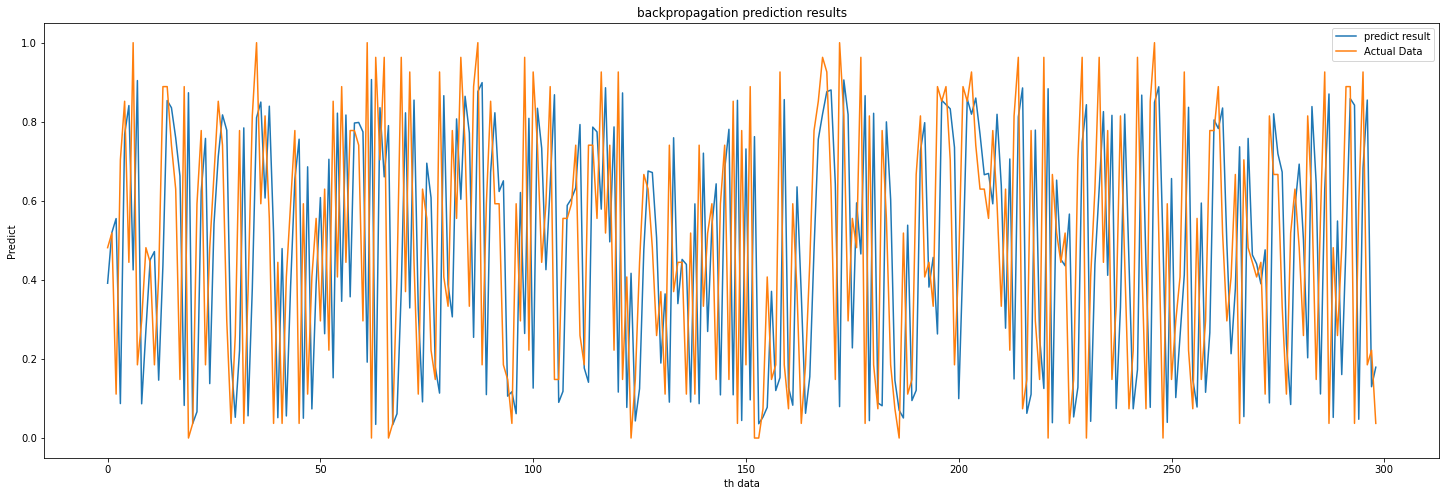

In [23]:
prediksi=model_1.arrayofY
prediksi=prediksi.reshape(len(prediksi),1)
grafPrediksi(prediksi, ytest)


## Menampilkan Grafik hasil Prediksi

In [22]:
newdata = np.array([[34],[30],[90],[80]])
prediksi = model_1.predict(newdata)
print("hasil prediksi :", round(denormalisasi(prediksi, np.min(data['semiwarna']), np.max(data['semiwarna']))[0,0]))

hasil prediksi : 82


In [21]:
arch = [4,7,1]
lr = 0.2
momentum = 0.6
batik = "semitulis"
epochs = 1000
MSE = 0.001
model =os.listdir("BPM")
for path in model:
    if batik in path and str(arch) in path and str(lr) in path and str(momentum) in path:
        path_select = path
        break
model_1=backpropagation(arch,lr,momentum, epochs, MSE)
model_1.loadModel('BPM/'+path_select)
model_1.test(xtest,ytest)

Berhasil Load Model BPM/batik=semitulis skenario arch=[4, 7, 1] learning_rate=0.2 momentum=0.6 epochs=1000.json
Testing MSE: 0.17851636551781647


# V. Melakukan Prediksi

In [22]:
model.test(xtest, ytest)

Testing MSE: 0.2784126270582612
